# Gathering the Tabular Data for Non-Winning songs

I recently found a website called *[KPOPDB](https://www.kpopdb.net/en/)* that contains not only the initial music show wins data from 2019 but the competition for each win. This provides more data as to how close a win was, the competitveness of a given week, but more importantly gives us an idea of songs that have never won a music show despite being in contention of one. If it appears that I require more songs, I will resort to scraping a release chart of different comebacks to consider in my analysis.

In [181]:
import requests
from bs4 import BeautifulSoup
import csv
import os
import re

def sanitize_filename(name: str) -> str:
    """
    Replace characters that aren't safe for filenames and replace spaces with underscores.
    """
    # Replace spaces with underscores first
    name = name.replace(" ", "_")
    # Replace any remaining unsafe characters
    return re.sub(r'[^\w\-\._]', '', name)

def scrape_kpopdb_year(year: int, save_dir = 'data/tables'):
    """
    Scrape https://www.kpopdb.net/en/wins.php?y={year}
    and create one CSV per show (e.g., 'Music Bank') 
    containing a header row + all placements.
    """
    base_url = "https://www.kpopdb.net/en/wins.php"
    resp = requests.get(f"{base_url}?y={year}")
    soup = BeautifulSoup(resp.text, "html.parser")
    
    # Collect all <tr> in the main table
    all_rows = soup.select("table.table tbody tr")
    
    # We'll group our data by show name
    data_by_show = {}
    
    current_show_name = ""
    current_date = ""
    
    for row in all_rows:
        row_id = row.get("id", "")
        
        # ---------------------------------------------------------------------
        # Process detail rows containing a nested table
        # ---------------------------------------------------------------------
        if row_id.startswith("detail"):
            nested_table = row.find("table")
            if not nested_table:
                continue
            
            nested_rows = nested_table.find_all("tr")
            
            # Only process if we have rows in the nested table
            if len(nested_rows) > 0:
                # 1A) Header row
                header_cells = nested_rows[0].find_all(["th", "td"])
                header_texts = [hc.get_text(strip=True) for hc in header_cells]
                # Replace the first three header cells with the desired names
                if len(header_texts) >= 3:
                    header_texts[0] = "Placement"
                    header_texts[1] = "Artist"
                    header_texts[2] = "Song"
                
                # Ensure show name is title cased
                show_key = (current_show_name or "Unknown Show").title().strip()
                if show_key not in data_by_show:
                    data_by_show[show_key] = {
                        "header": ["Show", "Date"] + header_texts,  # Prepend Show & Date
                        "rows": []
                    }
                
                # 1B) Process detail rows (skip the header row)
                for detail_row in nested_rows[1:]:
                    data_cells = detail_row.find_all("td")
                    if data_cells:
                        row_texts = [dc.get_text(strip=True) for dc in data_cells]
                        final_row = [current_show_name.title(), current_date] + row_texts
                        data_by_show[show_key]["rows"].append(final_row)
        
        # ---------------------------------------------------------------------
        # Process normal rows containing the show name and date
        # ---------------------------------------------------------------------
        else:
            cells = row.find_all("td")
            if len(cells) >= 2:
                # Adjusting the index for show name extraction and splitting if necessary
                # Convert show name to title case.
                show_name_raw = cells[2].get_text(strip=True).split(" #")[0]
                current_show_name = show_name_raw.title()
                current_date = cells[1].get_text(strip=True) + "-" + str(year)
    
    # -------------------------------------------------------------------------
    # Write out CSV files for each show program.
    # -------------------------------------------------------------------------
    for show_name, show_data in data_by_show.items():
        # The file name is generated using the year and the sanitized show name.
        filename = f"{year}_{sanitize_filename(show_name)}.csv"
        filename = os.path.join(save_dir, filename)
        print(f"Writing {filename} with {len(show_data['rows'])} rows...")
        
        with open(filename, mode="w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(show_data["header"])
            writer.writerows(show_data["rows"])

In [182]:
for year in range(2022, 2026):
    scrape_kpopdb_year(year)

Writing data/tables/2022_M_Countdown.csv with 45 rows...
Writing data/tables/2022_Show_Music_Core.csv with 37 rows...
Writing data/tables/2022_Show_Champion.csv with 41 rows...
Writing data/tables/2022_Inkigayo.csv with 51 rows...
Writing data/tables/2022_Music_Bank.csv with 49 rows...
Writing data/tables/2022_The_Show.csv with 35 rows...
Writing data/tables/2023_Music_Bank.csv with 98 rows...
Writing data/tables/2023_Show_Music_Core.csv with 95 rows...
Writing data/tables/2023_Inkigayo.csv with 100 rows...
Writing data/tables/2023_Show_Champion.csv with 132 rows...
Writing data/tables/2023_M_Countdown.csv with 67 rows...
Writing data/tables/2023_The_Show.csv with 55 rows...
Writing data/tables/2024_Show_Music_Core.csv with 120 rows...
Writing data/tables/2024_Music_Bank.csv with 106 rows...
Writing data/tables/2024_Inkigayo.csv with 119 rows...
Writing data/tables/2024_Show_Champion.csv with 194 rows...
Writing data/tables/2024_The_Show.csv with 75 rows...
Writing data/tables/2024_M_C

In [183]:
import os
import glob
import pandas as pd
import numpy as np

def gather_files(directory: str, pattern = "*"):
    """
    Gather all files in the specified directory that match the given pattern.
    """
    # Ensure the directory exists
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist.")
        return []
    
    # Use glob to find all files matching the pattern
    file_pattern = os.path.join(directory, pattern)
    files = glob.glob(file_pattern)
    
    return sorted(files)

def combine_csv_files(files: list, output_file: str):
    """ 
    Combine multiple CSV files into a single CSV file
    """
    # Read all CSV files into a list of DataFrames
    dataframes = []
    for file in files:
        df = pd.read_csv(file)
        dataframes.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes, ignore_index=True)

    # Write the combined DataFrame to a new CSV file
    combined_df.to_csv(output_file, index=False)
    print(f"Combined {len(files)} files into {output_file}")

def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the DataFrame 
    """

    # Convert 'Placement' column to numeric
    df['Placement'] = pd.to_numeric(df['Placement'], errors='coerce').astype("int64")

    # Ensure all columns from index 5 onward are numeric, fill NaNs, then convert to int64
    for col in df.columns[5:]:
        df[col] = df[col].astype(str).str.replace(",", "")
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype("int64")

    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    df.sort_values(by=["Date", "Placement"], ascending=[True, True], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

## Testing Functions and Looking at the Data

### Inkigayo

In [184]:
inkigayo = gather_files("data/tables", "*Inkigayo.csv")
combine_csv_files(inkigayo, "data/tables/all_inkigayo.csv")

Combined 4 files into data/tables/all_inkigayo.csv


In [185]:
inkigayo = pd.read_csv("data/tables/all_inkigayo.csv")
inkigayo.head()

,Show,Date,Placement,Artist,Song,Total,Album Sales,SNS (YouTube),Pre-Vote,On-Air,Live Vote,Digital
0,Inkigayo,12-11-2022,1.0,YOUNHA,Event Horizon,"6,164",NaN,NaN,NaN,NaN,NaN,NaN
1,Inkigayo,12-04-2022,1.0,YOUNHA,Event Horizon,"6,319",NaN,NaN,NaN,NaN,NaN,NaN
2,Inkigayo,11-27-2022,1.0,YOUNHA,Event Horizon,"6,482",NaN,NaN,NaN,NaN,NaN,NaN
3,Inkigayo,11-20-2022,1.0,(G)I-DLE,Nxde,"6,624",NaN,NaN,NaN,NaN,NaN,NaN
4,Inkigayo,11-13-2022,1.0,(G)I-DLE,Nxde,"9,164",NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
inkigayo.describe()

,Placement,Pre-Vote,Live Vote
count,311.000000,235.000000,235.000000
mean,1.964630,69.229787,236.936170
std,1.396552,89.114005,214.893395
min,1.000000,0.000000,0.000000
25%,1.000000,19.000000,28.000000
50%,2.000000,39.000000,174.000000
75%,3.000000,84.000000,500.000000
max,12.000000,500.000000,500.000000


In [187]:
inkigayo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Show           311 non-null    object 
 1   Date           311 non-null    object 
 2   Placement      311 non-null    float64
 3   Artist         311 non-null    object 
 4   Song           310 non-null    object 
 5   Total          311 non-null    object 
 6   Album Sales    235 non-null    object 
 7   SNS (YouTube)  235 non-null    object 
 8   Pre-Vote       235 non-null    float64
 9   On-Air         235 non-null    object 
 10  Live Vote      235 non-null    float64
 11  Digital        235 non-null    object 
dtypes: float64(3), object(9)
memory usage: 29.3+ KB


In [188]:
inkigayo[inkigayo.isnull().any(axis=1)]

,Show,Date,Placement,Artist,Song,Total,Album Sales,SNS (YouTube),Pre-Vote,On-Air,Live Vote,Digital
0,Inkigayo,12-11-2022,1.0,YOUNHA,Event Horizon,"6,164",NaN,NaN,NaN,NaN,NaN,NaN
1,Inkigayo,12-04-2022,1.0,YOUNHA,Event Horizon,"6,319",NaN,NaN,NaN,NaN,NaN,NaN
2,Inkigayo,11-27-2022,1.0,YOUNHA,Event Horizon,"6,482",NaN,NaN,NaN,NaN,NaN,NaN
3,Inkigayo,11-20-2022,1.0,(G)I-DLE,Nxde,"6,624",NaN,NaN,NaN,NaN,NaN,NaN
4,Inkigayo,11-13-2022,1.0,(G)I-DLE,Nxde,"9,164",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
147,Inkigayo,02-05-2023,1.0,NewJeans,Ditto,"6,006",NaN,NaN,NaN,NaN,NaN,NaN
148,Inkigayo,01-29-2023,1.0,NewJeans,Ditto,"7,119",NaN,NaN,NaN,NaN,NaN,NaN
149,Inkigayo,01-15-2023,1.0,NewJeans,OMG,"8,795",NaN,NaN,NaN,NaN,NaN,NaN
150,Inkigayo,01-08-2023,1.0,NewJeans,Ditto,"6,719",NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
inkigayo = preprocess_dataframe(inkigayo)
inkigayo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Show           311 non-null    object        
 1   Date           311 non-null    datetime64[ns]
 2   Placement      311 non-null    int64         
 3   Artist         311 non-null    object        
 4   Song           310 non-null    object        
 5   Total          311 non-null    int64         
 6   Album Sales    311 non-null    int64         
 7   SNS (YouTube)  311 non-null    int64         
 8   Pre-Vote       311 non-null    int64         
 9   On-Air         311 non-null    int64         
 10  Live Vote      311 non-null    int64         
 11  Digital        311 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 29.3+ KB


Observed in the code below, we can see that *HWASA's* song *NA* was incorrectly identified as a null value. I intend to fix any observed errors after we look into all of the data tables

In [190]:
inkigayo[inkigayo.isnull().any(axis=1)]

,Show,Date,Placement,Artist,Song,Total,Album Sales,SNS (YouTube),Pre-Vote,On-Air,Live Vote,Digital
247,Inkigayo,2024-10-06,2,HWASA,NaN,3120,4,2000,49,467,23,577


The line of code gives us some valuable insight particularly into the `placement` variable, where there appears to be values greater than 3. While this could have been possibly tracked as far as the 12th ranked entrant, I believe this is an error that I will examine in the next section.

In [191]:
inkigayo.describe()

,Date,Placement,Total,Album Sales,SNS (YouTube),Pre-Vote,On-Air,Live Vote,Digital
count,311,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,2023-12-12 04:56:20.064308736,1.964630,5924.475884,154.067524,781.086817,52.311897,183.520900,179.035370,2932.578778
min,2022-01-09 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-06-18 00:00:00,1.000000,5038.500000,0.000000,0.000000,0.000000,0.000000,0.000000,299.500000
50%,2024-01-14 00:00:00,2.000000,5974.000000,1.000000,302.000000,25.000000,61.000000,43.000000,3605.000000
75%,2024-08-25 00:00:00,3.000000,6797.500000,54.500000,1164.000000,56.000000,300.000000,500.000000,4900.500000
max,2025-04-06 00:00:00,12.000000,10586.000000,1000.000000,3000.000000,500.000000,1000.000000,500.000000,5500.000000
std,NaN,1.396552,1675.774232,328.209402,1020.168501,82.959429,247.042478,212.738235,2141.868768


In [192]:
inkigayo.head()

,Show,Date,Placement,Artist,Song,Total,Album Sales,SNS (YouTube),Pre-Vote,On-Air,Live Vote,Digital
0,Inkigayo,2022-01-09,1,IVE,ELEVEN,8533,0,0,0,0,0,0
1,Inkigayo,2022-01-16,1,IVE,ELEVEN,6583,0,0,0,0,0,0
2,Inkigayo,2022-01-23,1,IVE,ELEVEN,5927,0,0,0,0,0,0
3,Inkigayo,2022-01-30,1,GOT the beat,Step Back,5612,0,0,0,0,0,0
4,Inkigayo,2022-02-20,1,GOT the beat,Step Back,7224,0,0,0,0,0,0


### Music Bank

In [193]:
musicbank = gather_files("data/tables", "*Music_Bank.csv")
combine_csv_files(musicbank, "data/tables/all_musicbank.csv")
musicbank = pd.read_csv("data/tables/all_musicbank.csv")
musicbank = preprocess_dataframe(musicbank)
musicbank.info()

Combined 4 files into data/tables/all_musicbank.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Show            285 non-null    object        
 1   Date            285 non-null    datetime64[ns]
 2   Placement       285 non-null    int64         
 3   Artist          285 non-null    object        
 4   Song            285 non-null    object        
 5   Total           285 non-null    int64         
 6   Digital sales   285 non-null    int64         
 7   Broadcast       285 non-null    int64         
 8   Voting          285 non-null    int64         
 9   Physical album  285 non-null    int64         
 10  Video views     285 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 24.6+ KB


In [194]:
musicbank.describe()

,Date,Placement,Total,Digital sales,Broadcast,Voting,Physical album,Video views
count,285,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,2023-12-05 03:01:53.684210432,1.614035,6980.028070,793.449123,1563.533333,795.656140,1585.007018,70.252632
min,2022-01-07 00:00:00,1.000000,2180.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-05-26 00:00:00,1.000000,4704.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-12-15 00:00:00,1.000000,6667.000000,154.000000,1515.000000,172.000000,607.000000,15.000000
75%,2024-08-30 00:00:00,2.000000,8793.000000,1212.000000,2936.000000,1998.000000,2553.000000,87.000000
max,2025-04-04 00:00:00,5.000000,16281.000000,4668.000000,4953.000000,2000.000000,9282.000000,601.000000
std,NaN,0.899029,2930.952623,1132.702907,1520.838706,898.221126,2080.731382,117.107718


I noticed that there was a date that had rankings from 1-5 but was missing the second place entry. As observed below, the date *2023-12-08* is missing its second placed song. Based on some archives of the MusicBank placements that I was able to find, the missing song is `The First Snow` by EXO. Additionally, I found that there was another non-televised (the month of December appeared to not have many televised episodes) the week after where this song did win. Therefore, I will be manually adding this second place entry and the episode not scraped from the kpop database. These changes will be shown in the section after loading all of the other shows' datasets.

In [195]:
# Filter for rows where the Placement for 2 is missing
placement_counts = musicbank.groupby("Date")["Placement"].apply(set)
missing_seconds = placement_counts[~placement_counts.apply(lambda x: 2 in x)].index

# Filter for dates with multiple rows
date_counts = musicbank["Date"].value_counts()
dates_with_multiple_rows = date_counts[date_counts > 1].index

# Find the intersection of missing seconds and dates with multiple rows
missing_seconds = missing_seconds.intersection(dates_with_multiple_rows)
musicbank[musicbank['Date'].isin(missing_seconds)][-10:]

,Show,Date,Placement,Artist,Song,Total,Digital sales,Broadcast,Voting,Physical album,Video views
136,Music Bank,2023-12-08,1,ATEEZ,Crazy Form,10386,31,1774,1646,6917,18
137,Music Bank,2023-12-08,3,LE SSERAFIM,Perfect Night,2544,2307,15,5,0,217
138,Music Bank,2023-12-08,4,Taeyeon,To. X,2338,1839,38,0,453,8
139,Music Bank,2023-12-08,5,aespa,Drama,2180,2038,0,4,11,127


In [196]:
musicbank.tail()

,Show,Date,Placement,Artist,Song,Total,Digital sales,Broadcast,Voting,Physical album,Video views
280,Music Bank,2025-03-21,2,G-Dragon,TOO BAD (feat. Anderson Paak),5694,3276,12,1933,371,102
281,Music Bank,2025-03-28,1,NMIXX,KNOW ABOUT ME,11040,296,4804,2000,3924,16
282,Music Bank,2025-03-28,2,THE BOYZ,VVV,6667,32,2675,1813,2144,3
283,Music Bank,2025-04-04,1,TEN,STUNNER,7752,28,4050,2000,1666,8
284,Music Bank,2025-04-04,2,KiiiKiii,I DO ME,7148,1242,3613,56,2218,19


In [197]:
musicbank_diff = musicbank[musicbank['Placement'].isin([1, 2])].copy()
musicbank_diff.head()

,Show,Date,Placement,Artist,Song,Total,Digital sales,Broadcast,Voting,Physical album,Video views
0,Music Bank,2022-01-07,1,NCT U,Universe (Let's Play Ball),5930,0,0,0,0,0
1,Music Bank,2022-01-14,1,Kep1er,WA DA DA,3678,0,0,0,0,0
2,Music Bank,2022-01-21,1,ENHYPEN,Blessed-Cursed,8377,0,0,0,0,0
3,Music Bank,2022-01-28,1,IU,Winter Sleep,2949,0,0,0,0,0
4,Music Bank,2022-02-04,1,PENTAGON,Feelin' Like,3426,0,0,0,0,0


In [198]:
musicbank_diff_group = musicbank_diff.groupby(['Date', 'Placement'])['Total'].first().unstack()
musicbank_diff_group.head()

Placement,1,2
Date,,
2022-01-07,5930.0,NaN
2022-01-14,3678.0,NaN
2022-01-21,8377.0,NaN
2022-01-28,2949.0,NaN
2022-02-04,3426.0,NaN


In [199]:
musicbank_diff_group = musicbank_diff_group.dropna(subset=[1, 2])
musicbank_diff_group.head()

Placement,1,2
Date,,
2023-05-12,13498.0,5135.0
2023-05-19,11842.0,7313.0
2023-06-02,12595.0,5909.0
2023-06-09,13481.0,5037.0
2023-06-16,8333.0,6053.0


In [200]:
musicbank_diff_group = musicbank_diff_group.rename(columns={1: "1st", 2: "2nd"})
musicbank_diff_group["ScoreDifference"] = musicbank_diff_group["1st"] - musicbank_diff_group["2nd"]
musicbank_diff_group.head()

Placement,1st,2nd,ScoreDifference
Date,,,
2023-05-12,13498.0,5135.0,8363.0
2023-05-19,11842.0,7313.0,4529.0
2023-06-02,12595.0,5909.0,6686.0
2023-06-09,13481.0,5037.0,8444.0
2023-06-16,8333.0,6053.0,2280.0


In [201]:
musicbank_diff_group.describe()

Placement,1st,2nd,ScoreDifference
count,93.000000,93.000000,93.000000
mean,8666.645161,5331.537634,3335.107527
std,2516.851992,1444.415562,2630.795030
min,3389.000000,2499.000000,34.000000
25%,6788.000000,4148.000000,1085.000000
50%,8335.000000,5127.000000,2770.000000
75%,10488.000000,6053.000000,4648.000000
max,16281.000000,9876.000000,12803.000000


<Axes: >

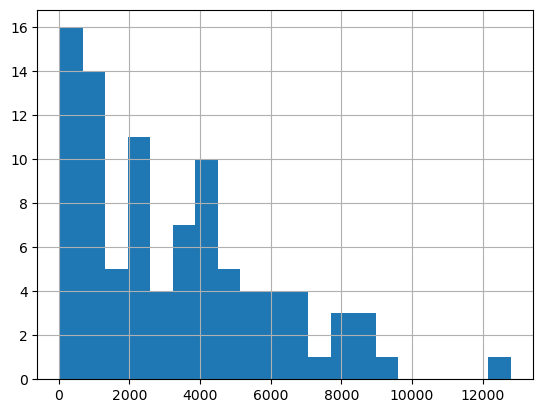

In [202]:
musicbank_diff_group["ScoreDifference"].hist(bins=20)

In [203]:
musicbank_diff_group.iloc[musicbank_diff_group["ScoreDifference"].argmin()]

Placement
1st                6587.0
2nd                6553.0
ScoreDifference      34.0
Name: 2023-09-22 00:00:00, dtype: float64

In [204]:
musicbank.loc[musicbank['Date'] == "2023-09-22"]

,Show,Date,Placement,Artist,Song,Total,Digital sales,Broadcast,Voting,Physical album,Video views
107,Music Bank,2023-09-22,1,V,Slow Dancing,6587,437,2121,2000,1942,87
108,Music Bank,2023-09-22,2,Cravity,Ready Or Not,6553,20,2912,1047,2573,1


In [205]:
musicbank_diff_group.iloc[musicbank_diff_group["ScoreDifference"].argmax()]

Placement
1st                16281.0
2nd                 3478.0
ScoreDifference    12803.0
Name: 2023-11-03 00:00:00, dtype: float64

In [206]:
musicbank.loc[musicbank['Date'] == "2023-11-03"]

,Show,Date,Placement,Artist,Song,Total,Digital sales,Broadcast,Voting,Physical album,Video views
126,Music Bank,2023-11-03,1,SEVENTEEN,God of Music,16281,1236,3715,2000,9282,48
127,Music Bank,2023-11-03,2,IVE,Baddie,3478,2027,1059,268,8,116


### M Countdown

In [207]:
mcountdown = gather_files("data/tables", "*M_Countdown.csv")
combine_csv_files(mcountdown, "data/tables/all_mcountdown.csv")
mcountdown_df = pd.read_csv("data/tables/all_mcountdown.csv")
m_countdown_df = preprocess_dataframe(mcountdown_df)
m_countdown_df.info()

Combined 4 files into data/tables/all_mcountdown.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Show                          221 non-null    object        
 1   Date                          221 non-null    datetime64[ns]
 2   Placement                     221 non-null    int64         
 3   Artist                        221 non-null    object        
 4   Song                          221 non-null    object        
 5   Total                         221 non-null    int64         
 6   Digital (Circle Global Kpop)  221 non-null    int64         
 7   Physical (Circle Album)       221 non-null    int64         
 8   SNS (YouTube)                 221 non-null    int64         
 9   Pre-vote                      221 non-null    int64         
 10  Broadcast                     221 non-null   

In [208]:
m_countdown_df.describe()

,Date,Placement,Total,Digital (Circle Global Kpop),Physical (Circle Album),SNS (YouTube),Pre-vote,Broadcast,Live Vote (Hidden)
count,221,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,2023-11-02 14:26:36.380090624,1.343891,6253.443439,2445.036199,313.199095,513.266968,393.104072,215.475113,397.180995
min,2022-01-13 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-03-23 00:00:00,1.000000,5460.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-11-16 00:00:00,1.000000,6720.000000,2568.000000,0.000000,437.000000,98.000000,0.000000,126.000000
75%,2024-07-18 00:00:00,2.000000,8147.000000,5000.000000,203.000000,921.000000,974.000000,323.000000,1000.000000
max,2025-04-10 00:00:00,2.000000,11000.000000,5000.000000,1500.000000,1500.000000,1500.000000,1000.000000,1000.000000
std,NaN,0.476084,2840.135465,2189.125147,561.409271,511.080030,514.881401,330.349437,442.579807


In [209]:
m_countdown_df.tail()

,Show,Date,Placement,Artist,Song,Total,Digital (Circle Global Kpop),Physical (Circle Album),SNS (YouTube),Pre-vote,Broadcast,Live Vote (Hidden)
216,M Countdown,2025-03-27,2,NMIXX,KNOW ABOUT ME,5361,1053,1500,876,110,822,1000
217,M Countdown,2025-04-03,1,JENNIE,like JENNIE,6636,5000,39,1255,135,0,207
218,M Countdown,2025-04-03,2,J-Hope,MONA LISA,5404,2387,0,995,1000,22,1000
219,M Countdown,2025-04-10,1,J-Hope,MONA LISA,7638,5000,0,616,1000,22,1000
220,M Countdown,2025-04-10,2,LE SSERAFIM,HOT,4930,4353,114,254,23,141,45


### Show Champion

In [210]:
showchampion = gather_files("data/tables", "*Show_Champion.csv")
combine_csv_files(showchampion, "data/tables/all_showchampion.csv")
showchampion_df = pd.read_csv("data/tables/all_showchampion.csv")
showchampion_df = preprocess_dataframe(showchampion_df)
showchampion_df.info()

Combined 4 files into data/tables/all_showchampion.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Show       402 non-null    object        
 1   Date       402 non-null    datetime64[ns]
 2   Placement  402 non-null    int64         
 3   Artist     402 non-null    object        
 4   Song       402 non-null    object        
 5   Total      402 non-null    int64         
 6   Digital    402 non-null    int64         
 7   Physical   402 non-null    int64         
 8   Pre-vote   402 non-null    int64         
 9   SNS        402 non-null    int64         
 10  Broadcast  402 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 34.7+ KB


In [211]:
showchampion_df.describe()

,Date,Placement,Total,Digital,Physical,Pre-vote,SNS,Broadcast
count,402,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,2024-01-18 06:37:36.716417792,2.711443,3985.606965,1255.390547,437.987562,634.248756,393.435323,352.009950
min,2022-01-19 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-08-02 00:00:00,1.000000,2600.500000,0.000000,0.000000,7.000000,32.000000,0.000000
50%,2024-02-28 00:00:00,3.000000,3777.000000,560.500000,48.000000,139.500000,218.500000,0.000000
75%,2024-07-31 00:00:00,4.000000,5043.000000,2557.000000,891.750000,1490.250000,731.250000,400.000000
max,2025-04-09 00:00:00,5.000000,10679.000000,3500.000000,3984.000000,2000.000000,4768.000000,2000.000000
std,NaN,1.485195,1785.453469,1361.820149,621.907613,806.507379,453.753635,628.852567


In [212]:
showchampion_df.tail()

,Show,Date,Placement,Artist,Song,Total,Digital,Physical,Pre-vote,SNS,Broadcast
397,Show Champion,2025-04-09,1,NiziU,LOVE LINE,4823,0,490,2000,333,2000
398,Show Champion,2025-04-09,2,CLOSE YOUR EYES,All My Poetry,4709,418,1500,55,736,2000
399,Show Champion,2025-04-09,3,LE SSERAFIM,HOT,3834,3500,17,163,154,0
400,Show Champion,2025-04-09,4,KiiiKiii,I DO ME,3234,3199,18,7,10,0
401,Show Champion,2025-04-09,5,xikers,BREATHE,2803,103,435,37,228,2000


### Show! Music Core

In [213]:
musiccore = gather_files("data/tables", "*Show_Music_Core.csv")
combine_csv_files(musiccore, "data/tables/all_musiccore.csv")
musiccore_df = pd.read_csv("data/tables/all_musiccore.csv")
musiccore_df = preprocess_dataframe(musiccore_df)
musiccore_df.info()

Combined 4 files into data/tables/all_musiccore.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Show              285 non-null    object        
 1   Date              285 non-null    datetime64[ns]
 2   Placement         285 non-null    int64         
 3   Artist            285 non-null    object        
 4   Song              285 non-null    object        
 5   Total             285 non-null    int64         
 6   Digital (CIRCLE)  285 non-null    int64         
 7   Album (CIRCLE)    285 non-null    int64         
 8   SNS (YouTube)     285 non-null    int64         
 9   Broadcast         285 non-null    int64         
 10  V.Committee       285 non-null    int64         
 11  Global Pre-Vote   285 non-null    int64         
 12  Text Live Vote    285 non-null    int64         
 13  App Live Vote     285 non-nu

In [214]:
musiccore_df.describe()

,Date,Placement,Total,Digital (CIRCLE),Album (CIRCLE),SNS (YouTube),Broadcast,V.Committee,Global Pre-Vote,Text Live Vote,App Live Vote
count,285,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,2024-01-08 02:06:18.947368448,1.803509,5986.792982,2471.417544,164.652632,257.943860,187.112281,176.221053,231.263158,171.312281,158.428070
min,2022-01-08 00:00:00,1.000000,2541.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-07-01 00:00:00,1.000000,5010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2024-02-24 00:00:00,2.000000,5982.000000,2868.000000,0.000000,81.000000,100.000000,128.000000,260.000000,53.000000,22.000000
75%,2024-09-14 00:00:00,3.000000,6893.000000,4723.000000,85.000000,403.000000,300.000000,299.000000,450.000000,380.000000,382.000000
max,2025-04-05 00:00:00,3.000000,9800.000000,5000.000000,1000.000000,1000.000000,1000.000000,500.000000,500.000000,500.000000,500.000000
std,NaN,0.832856,1461.255430,2031.793653,327.689181,346.919589,236.372754,177.805689,200.739349,203.973531,207.794927


In [215]:
musiccore_df.tail()

,Show,Date,Placement,Artist,Song,Total,Digital (CIRCLE),Album (CIRCLE),SNS (YouTube),Broadcast,V.Committee,Global Pre-Vote,Text Live Vote,App Live Vote
280,Show! Music Core,2025-03-29,2,THE BOYZ,VVV,5141,1822,546,1000,240,500,400,500,133
281,Show! Music Core,2025-03-29,3,JENNIE,like JENNIE,4335,4093,32,0,0,136,60,12,2
282,Show! Music Core,2025-04-05,1,KiiiKiii,I DO ME,5936,3088,1000,34,800,272,220,500,22
283,Show! Music Core,2025-04-05,2,JENNIE,like JENNIE,5650,5000,26,0,0,204,180,92,148
284,Show! Music Core,2025-04-05,3,LE SSERAFIM,HOT,5367,3140,35,408,102,224,500,458,500


### The Show

In [216]:
theshow = gather_files("data/tables", "*The_Show.csv")
combine_csv_files(theshow, "data/tables/all_theshow.csv")
theshow_df = pd.read_csv("data/tables/all_theshow.csv")
theshow_df = preprocess_dataframe(theshow_df)
theshow_df.info()

Combined 4 files into data/tables/all_theshow.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Show              180 non-null    object        
 1   Date              180 non-null    datetime64[ns]
 2   Placement         180 non-null    int64         
 3   Artist            180 non-null    object        
 4   Song              180 non-null    object        
 5   Total             180 non-null    int64         
 6   Digital (CIRCLE)  180 non-null    int64         
 7   Album (Hanteo)    180 non-null    int64         
 8   SNS (YouTube)     180 non-null    int64         
 9   Pre-vote          180 non-null    int64         
 10  Broadcast         180 non-null    int64         
 11  Live Vote         180 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 17.0+ KB


Similar to the Inkigayo `Placement` values high max value, we see a similar value for The Show. We will also inspect this value in the next section.

In [217]:
theshow_df.describe()

,Date,Placement,Total,Digital (CIRCLE),Album (Hanteo),SNS (YouTube),Pre-vote,Broadcast,Live Vote
count,180,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,2023-11-06 20:16:00,1.833333,5921.850000,1325.588889,249.911111,784.622222,152.594444,494.394444,293.194444
min,2022-01-25 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-05-28 06:00:00,1.000000,3372.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-12-05 00:00:00,2.000000,6513.500000,258.000000,10.000000,440.000000,20.000000,592.500000,53.500000
75%,2024-06-26 18:00:00,3.000000,8215.250000,3342.500000,312.500000,1590.000000,365.000000,920.000000,553.250000
max,2025-04-08 00:00:00,12.000000,9700.000000,5000.000000,1000.000000,3240.000000,500.000000,1500.000000,1000.000000
std,NaN,1.126125,2565.754162,1677.373069,389.618167,867.841792,206.292809,474.471332,398.453913


In [218]:
theshow_df.tail()

,Show,Date,Placement,Artist,Song,Total,Digital (CIRCLE),Album (Hanteo),SNS (YouTube),Pre-vote,Broadcast,Live Vote
175,The Show,2025-04-01,2,STAYC,BEBE,6880,3570,140,2000,170,930,70
176,The Show,2025-04-01,3,THE NEW SIX,For Real!?,2139,100,100,1200,30,690,19
177,The Show,2025-04-08,1,CLOSE YOUR EYES,All My Poetry,8605,4000,1000,2000,380,740,485
178,The Show,2025-04-08,2,TEMPEST,Unfreeze,6330,3510,160,280,500,880,1000
179,The Show,2025-04-08,3,xikers,BREATHE,3245,1360,300,550,140,850,45


## Manual Fixes from Observing the Data

### Inkigayo Fix

We need to convert *HWASA's* song from `NaN` to `NA` 

In [219]:
inkigayo.loc[inkigayo.Artist == "HWASA", "Song"] = "NA"

Upon inspection of the `Placement` values observed earlier, we can see that the rankings for `2023-08-20` were intentional and should be kept for the analysis. However, we should did into placements for `2022-07-24` as there aren't any preceding rankings similar to the `2023-08-20` episode.

In [220]:
inkigayo[inkigayo['Placement'] > 3]

,Show,Date,Placement,Artist,Song,Total,Album Sales,SNS (YouTube),Pre-Vote,On-Air,Live Vote,Digital
29,Inkigayo,2022-07-24,11,aespa,Girls,6262,0,0,0,0,0,0
30,Inkigayo,2022-07-24,12,ITZY,SNEAKERS,4656,0,0,0,0,0,0
107,Inkigayo,2023-08-20,4,SOMI,Fast Forward,0,0,0,0,0,0,0
108,Inkigayo,2023-08-20,5,Parc Jae-jung,Let's Say Goodbye,0,0,0,0,0,0,0
109,Inkigayo,2023-08-20,6,V,Love Me Again,0,0,0,0,0,0,0
110,Inkigayo,2023-08-20,7,LE SSERAFIM,"Eve, Psyche & The Bluebeard’s wife",0,0,0,0,0,0,0
111,Inkigayo,2023-08-20,8,aespa,Spicy,0,0,0,0,0,0,0
112,Inkigayo,2023-08-20,9,IVE,Kitsch,0,0,0,0,0,0,0
113,Inkigayo,2023-08-20,10,LE SSERAFIM,UNFORGIVEN (Feat. Nile Rodgers),0,0,0,0,0,0,0


In [221]:
inkigayo[inkigayo['Date'] == "2022-07-24"]

,Show,Date,Placement,Artist,Song,Total,Album Sales,SNS (YouTube),Pre-Vote,On-Air,Live Vote,Digital
28,Inkigayo,2022-07-24,1,Nayeon,POP!,7103,0,0,0,0,0,0
29,Inkigayo,2022-07-24,11,aespa,Girls,6262,0,0,0,0,0,0
30,Inkigayo,2022-07-24,12,ITZY,SNEAKERS,4656,0,0,0,0,0,0


We can now observe that this was a simple error where we can properly assign the `Placement` values for theses entrants.

In [222]:
inkigayo.iloc[29, 2] = 2
inkigayo.iloc[30, 2] = 3
inkigayo[inkigayo['Date'] == "2022-07-24"]

,Show,Date,Placement,Artist,Song,Total,Album Sales,SNS (YouTube),Pre-Vote,On-Air,Live Vote,Digital
28,Inkigayo,2022-07-24,1,Nayeon,POP!,7103,0,0,0,0,0,0
29,Inkigayo,2022-07-24,2,aespa,Girls,6262,0,0,0,0,0,0
30,Inkigayo,2022-07-24,3,ITZY,SNEAKERS,4656,0,0,0,0,0,0


In [223]:
inkigayo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Show           311 non-null    object        
 1   Date           311 non-null    datetime64[ns]
 2   Placement      311 non-null    int64         
 3   Artist         311 non-null    object        
 4   Song           311 non-null    object        
 5   Total          311 non-null    int64         
 6   Album Sales    311 non-null    int64         
 7   SNS (YouTube)  311 non-null    int64         
 8   Pre-Vote       311 non-null    int64         
 9   On-Air         311 non-null    int64         
 10  Live Vote      311 non-null    int64         
 11  Digital        311 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 29.3+ KB


### Music Bank Fixes

First we are going to add the second place finish for `2023-12-08` by *EXO's *The First Snow** 

In [224]:
# Filter for rows where the Placement for 2 is missing
placement_counts = musicbank.groupby("Date")["Placement"].apply(set)
missing_seconds = placement_counts[~placement_counts.apply(lambda x: 2 in x)].index

# Filter for dates with multiple rows
date_counts = musicbank["Date"].value_counts()
dates_with_multiple_rows = date_counts[date_counts > 1].index

# Find the intersection of missing seconds and dates with multiple rows
missing_seconds = missing_seconds.intersection(dates_with_multiple_rows)
musicbank[musicbank['Date'].isin(missing_seconds)][-10:]

,Show,Date,Placement,Artist,Song,Total,Digital sales,Broadcast,Voting,Physical album,Video views
136,Music Bank,2023-12-08,1,ATEEZ,Crazy Form,10386,31,1774,1646,6917,18
137,Music Bank,2023-12-08,3,LE SSERAFIM,Perfect Night,2544,2307,15,5,0,217
138,Music Bank,2023-12-08,4,Taeyeon,To. X,2338,1839,38,0,453,8
139,Music Bank,2023-12-08,5,aespa,Drama,2180,2038,0,4,11,127


In [225]:
first_snow_second = pd.DataFrame({
    "Show": ["Music Bank"],
    "Date": ["2023-12-08 00:00:00"],
    "Placement": [2],
    "Artist": ["EXO"],
    "Song": ["The First Snow"],
    "Total": [2889],
    "Digital sales": [848],
    "Broadcast": [15],
    "Voting": [2000],
    "Physical album": [0],
    "Video views": [26] 
})

musicbank_fsnow = pd.concat([musicbank, first_snow_second], ignore_index=True)
musicbank_fsnow.tail()

,Show,Date,Placement,Artist,Song,Total,Digital sales,Broadcast,Voting,Physical album,Video views
281,Music Bank,2025-03-28 00:00:00,1,NMIXX,KNOW ABOUT ME,11040,296,4804,2000,3924,16
282,Music Bank,2025-03-28 00:00:00,2,THE BOYZ,VVV,6667,32,2675,1813,2144,3
283,Music Bank,2025-04-04 00:00:00,1,TEN,STUNNER,7752,28,4050,2000,1666,8
284,Music Bank,2025-04-04 00:00:00,2,KiiiKiii,I DO ME,7148,1242,3613,56,2218,19
285,Music Bank,2023-12-08 00:00:00,2,EXO,The First Snow,2889,848,15,2000,0,26


Next, I noticed that there's an instance on `2023-07-07` where the **SEVENTEEN** song **_WORLD** is mispelled to be simply **World**

In [226]:
musicbank_fsnow.loc[musicbank_fsnow['Song'] == "World", "Song"] = "_WORLD"

The upcoming fixes are for the `2023-12-29` episode of *Music Bank* where *EXO's *The First Snow** won first place. Including this is important because it ensures that the song is considered as a winner rather than a non-winning song. From what I have seen, there were no other programs that had non-televised shows or shows where a winner wasn't announced

In [227]:
musicbank[musicbank["Artist"] == "Red Velvet"]

,Show,Date,Placement,Artist,Song,Total,Digital sales,Broadcast,Voting,Physical album,Video views
12,Music Bank,2022-04-01,1,Red Velvet,Feel My Rhythm,8416,0,0,0,0,0
133,Music Bank,2023-11-24,2,Red Velvet,Chill Kill,5819,950,3400,76,1362,31
196,Music Bank,2024-07-05,2,Red Velvet,Cosmic,7148,628,2999,1939,1529,53


In [228]:
december_29_2023 = pd.DataFrame({
    "Show": ["Music Bank", "Music Bank", "Music Bank", "Music Bank", "Music Bank"],
    "Date": ["2023-12-29 00:00:00", "2023-12-29 00:00:00", "2023-12-29 00:00:00", "2023-12-29 00:00:00", "2023-12-29 00:00:00"],
    "Placement": [1, 2, 3, 4, 5],
    "Artist": ["EXO", "Red Velvet", "Taeyeon", "LE SSERAFIM", "aespa"],
    "Song": ["The First Snow", "Chill Kill","To. X", "Perfect Night", "Drama"],
    "Total": [4543, 3313, 2478, 2383, 2197],
    "Digital sales": [2399, 767, 1820, 2202, 1929],
    "Broadcast": [32, 0, 8, 16, 0],
    "Voting": [2000, 6, 1, 1, 2],
    "Physical album": [0, 2515, 642, 0, 162],
    "Video views": [112, 25, 7, 164, 104] 
})

musicbank_clean = pd.concat([musicbank_fsnow, december_29_2023], ignore_index=True)
musicbank_clean = preprocess_dataframe(musicbank_clean)

In [229]:
musicbank_clean.loc[musicbank_clean["Date"] == "2023-12-29"]

,Show,Date,Placement,Artist,Song,Total,Digital sales,Broadcast,Voting,Physical album,Video views
148,Music Bank,2023-12-29,1,EXO,The First Snow,4543,2399,32,2000,0,112
149,Music Bank,2023-12-29,2,Red Velvet,Chill Kill,3313,767,0,6,2515,25
150,Music Bank,2023-12-29,3,Taeyeon,To. X,2478,1820,8,1,642,7
151,Music Bank,2023-12-29,4,LE SSERAFIM,Perfect Night,2383,2202,16,1,0,164
152,Music Bank,2023-12-29,5,aespa,Drama,2197,1929,0,2,162,104


In [230]:
musicbank_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Show            291 non-null    object        
 1   Date            291 non-null    datetime64[ns]
 2   Placement       291 non-null    int64         
 3   Artist          291 non-null    object        
 4   Song            291 non-null    object        
 5   Total           291 non-null    int64         
 6   Digital sales   291 non-null    int64         
 7   Broadcast       291 non-null    int64         
 8   Voting          291 non-null    int64         
 9   Physical album  291 non-null    int64         
 10  Video views     291 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 25.1+ KB


### The Show

In [231]:
theshow_df[theshow_df['Placement'] > 3]

,Show,Date,Placement,Artist,Song,Total,Digital (CIRCLE),Album (Hanteo),SNS (YouTube),Pre-vote,Broadcast,Live Vote
10,The Show,2022-04-19,12,DKZ,Cupid,3560,0,0,0,0,0,0


When viewing this specific date, we can see that the placements for 2 and 3 are incorrect. This may be indicative of this show's ranking or simply be a one-off mistyping of the ranking.

In [232]:
theshow_df[theshow_df['Date'] == "2022-04-19"]

,Show,Date,Placement,Artist,Song,Total,Digital (CIRCLE),Album (Hanteo),SNS (YouTube),Pre-vote,Broadcast,Live Vote
8,The Show,2022-04-19,1,IVE,LOVE DIVE,8184,0,0,0,0,0,0
9,The Show,2022-04-19,2,Dreamcatcher,MAISON,3559,0,0,0,0,0,0
10,The Show,2022-04-19,12,DKZ,Cupid,3560,0,0,0,0,0,0


In [233]:
theshow_df_clean = theshow_df.copy()
theshow_df_clean.iloc[10, 2] = 2
theshow_df_clean.iloc[9, 2] = 3

### Finding Non-Winners within each show

In [234]:
def non_winner_filter(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters the DataFrame to include only songs that have never won within a given show.
    """
    # Gather songs that have won
    winners = df[df['Placement'] == 1].copy()
    winners = winners[['Artist', 'Song']].drop_duplicates()
    winners.reset_index(drop=True, inplace=True)

    # Gather the songs that have never won
    non_winners = df[~df[['Artist', 'Song']].apply(tuple, axis=1).isin(winners.apply(tuple, axis=1))]
    return non_winners

In [235]:
# Extract first 6 columns of the dataframes to then merge
inkigayo_merge = inkigayo.iloc[:, :6].copy()
musicbank_merge = musicbank_clean.iloc[:, :6].copy()
m_countdown_merge = m_countdown_df.iloc[:, :6].copy()
showchampion_merge = showchampion_df.iloc[:, :6].copy()
musiccore_merge = musiccore_df.iloc[:, :6].copy()
theshow_merge = theshow_df_clean.iloc[:, :6].copy()

# Merge all DataFrames
merged_df = pd.concat([inkigayo_merge, musicbank_merge, m_countdown_merge, showchampion_merge, musiccore_merge, theshow_merge], ignore_index=True)

In [236]:
# merged_df.Artist = merged_df.Artist.str.title()
# merged_df

In [237]:
merged_df_non_winners = non_winner_filter(merged_df).reset_index(drop=True)

unique_non_winners = merged_df_non_winners[['Artist', 'Song']].drop_duplicates()
unique_non_winners.reset_index(drop=True, inplace=True)
unique_non_winners

,Artist,Song
0,Parc Jae-jung,Let's Say Goodbye
1,SOMI,Fast Forward
2,RIIZE,Get A Guitar
3,AKMU,Fry's Dream
4,JENNIE,You & Me
...,...,...
169,ARrC,nu kidz
170,GENBLUE,ACT LIKE THAT
171,SAY MY NAME,ShaLala
172,The Wind,Only One


In [238]:
unique_non_winners.to_csv("data/tables/unique_non_winners.csv", index=False)
merged_df_non_winners.to_csv("data/tables/all_award_show_non_winners.csv", index=False)

With these .csv files created, we can now begin to download the music within the `gather_audio_data.ipynb` file.